## All Steps

<br>
<font size="5">
This notebook is for visualizing the entire process. It will give you a better insight into this project.
</font>
<br><br><br><br>

<br>

## Necessary Libraries

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
!pip install ultralytics
from ultralytics import YOLO
import  math
import ultralytics
import csv
!pip install svglib
from svglib.svglib import svg2rlg
!pip install reportlab
from reportlab.graphics import renderPM
from ultralytics import YOLO
from PIL import Image
import os
!pip install chess
import chess
import chess.svg


<br>

## Display Image

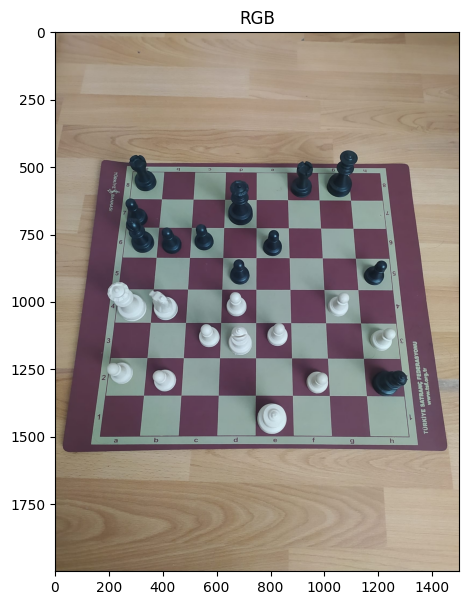

In [10]:
# Path of Image that you want to convert
image_path = "/test-10.jpeg"

# read image and convert it to different color spaces
image = cv2.imread(image_path)
gray_image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
rgb_image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(9,7))
plt.imshow(rgb_image)
plt.title("RGB");

<br>


## Processing Image
####  OTSU Threshold , Canny , dilate , HoughLinesP

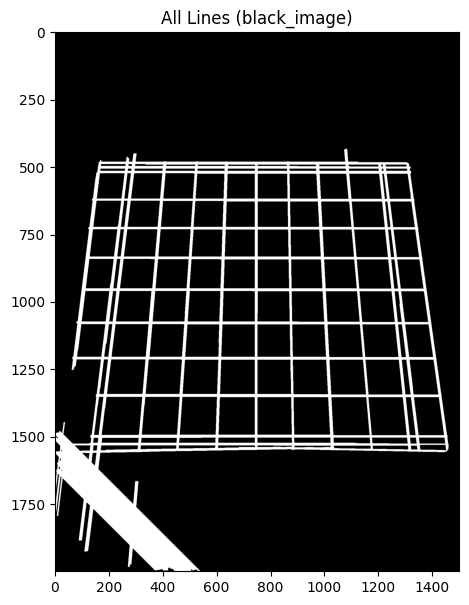

In [11]:
# Gaussian Blur
#gaussian_blur = cv2.GaussianBlur(gray_image, (5, 5), 0)

# OTSU threshold
ret, otsu_binary = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Canny edge detection
canny = cv2.Canny(otsu_binary, 20, 255)

# Dilation
kernel = np.ones((7, 7), np.uint8)
img_dilation = cv2.dilate(canny, kernel, iterations=1)

# Hough Lines
lines = cv2.HoughLinesP(img_dilation, 1, np.pi / 180, threshold=500, minLineLength=150, maxLineGap=100)


# Create an image that contains only black pixels
black_image = np.zeros_like(img_dilation)

# Draw only lines that are output of HoughLinesP function to the "black_image"
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # draw only lines to the "black_image"
        cv2.line(black_image, (x1, y1), (x2, y2), (255, 255, 255), 2)

# Dilation
kernel = np.ones((3, 3), np.uint8)
black_image = cv2.dilate(black_image, kernel, iterations=1)

plt.figure(figsize=(9,7))
plt.title("All Lines (black_image)")
plt.imshow(black_image,cmap="gray");


<br>


## Find Contours , sort contours points(4 point), and display valid squares on new fully black image

#### By saying "valid squares" , I mean geometrically. With some threshold value , 4 length of a square must be close to each other

#### 4 point --> bottomright , topright , topleft , bottomleft

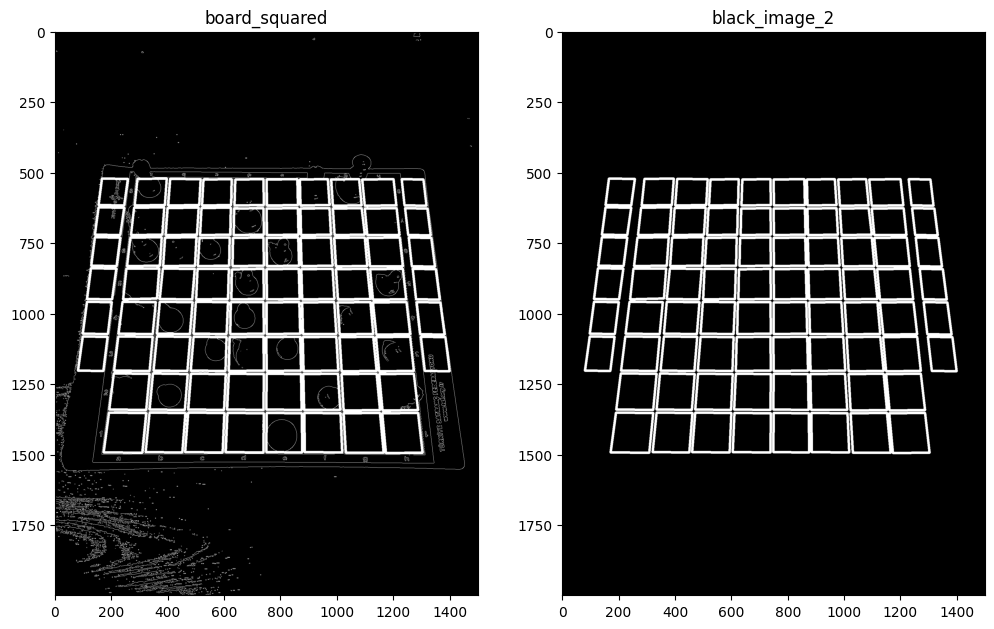

In [ ]:
# Look for valid squares and check if squares are inside of board

# find contours
board_contours, hierarchy = cv2.findContours(black_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# create image that contains only black pixels
black_image_2 = np.zeros_like(black_image)

# list for storing the center coordinates of squares
square_centers=list()

# Copy the board image
board_squared = canny.copy() # CANNY IMAGE

# loop through contours and filter them by deciding if they are potential squares
for contour in board_contours:
    if 2000 < cv2.contourArea(contour) < 20000:

        # Approximate the contour to a simpler shape
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # if polygon has 4 vertices
        if len(approx) == 4:

            # 4 points of polygon
            pts = [pt[0].tolist() for pt in approx]

            # create same pattern for points , bottomright(1) , topright(2) , topleft(3) , bottomleft(4)
            index_sorted = sorted(pts, key=lambda x: x[0], reverse=True)

            #  Y values
            if index_sorted[0][1]< index_sorted[1][1]:
                cur=index_sorted[0]
                index_sorted[0] =  index_sorted[1]
                index_sorted[1] = cur

            if index_sorted[2][1]> index_sorted[3][1]:
                cur=index_sorted[2]
                index_sorted[2] =  index_sorted[3]
                index_sorted[3] = cur

            # bottomright(1) , topright(2) , topleft(3) , bottomleft(4)
            pt1=index_sorted[0]
            pt2=index_sorted[1]
            pt3=index_sorted[2]
            pt4=index_sorted[3]

            # find rectangle that fits 4 point
            x, y, w, h = cv2.boundingRect(contour)
            # find center of rectangle
            center_x=(x+(x+w))/2
            center_y=(y+(y+h))/2

            # calculate length of 4 side of rectangle
            l1 = math.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
            l2 = math.sqrt((pt2[0] - pt3[0])**2 + (pt2[1] - pt3[1])**2)
            l3 = math.sqrt((pt3[0] - pt4[0])**2 + (pt3[1] - pt4[1])**2)
            l4 = math.sqrt((pt1[0] - pt4[0])**2 + (pt1[1] - pt4[1])**2)


            # Create a list of lengths
            lengths = [l1, l2, l3, l4]

            # Get the maximum and minimum lengths
            max_length = max(lengths)
            min_length = min(lengths)

            # Check if this length values are suitable for a square , this threshold value plays crucial role for squares ,
            valid_square=True
            if (max_length - min_length) <= 35: # 20 for smaller boards  , 50 for bigger , 35 works most of the time
                pass
            else:
                valid_square=False


             # if algorithm decides it is a square , add it to "square_centers" list
            if valid_square:
                square_centers.append([center_x,center_y,pt1,pt2,pt3,pt4])

                # Draw the lines between the points
                cv2.line(board_squared, pt1, pt2, (255, 255, 0), 7)
                cv2.line(board_squared, pt2, pt3, (255, 255, 0), 7)
                cv2.line(board_squared, pt3, pt4, (255, 255, 0), 7)
                cv2.line(board_squared, pt1, pt4, (255, 255, 0), 7)

                # Draw only valid squares to "black_image_2"
                cv2.line(black_image_2, pt1, pt2, (255, 255, 0), 7)
                cv2.line(black_image_2, pt2, pt3, (255, 255, 0), 7)
                cv2.line(black_image_2, pt3, pt4, (255, 255, 0), 7)
                cv2.line(black_image_2, pt1, pt4, (255, 255, 0), 7)

plt.figure(figsize=(12,8))


plt.subplot(121)
plt.title("board_squared")
plt.imshow(board_squared,cmap="gray")

plt.subplot(122)
plt.title("black_image_2")
plt.imshow(black_image_2,cmap="gray")




<br>


## Dilation to the image that contains only valid squares (gemoetrically valid)

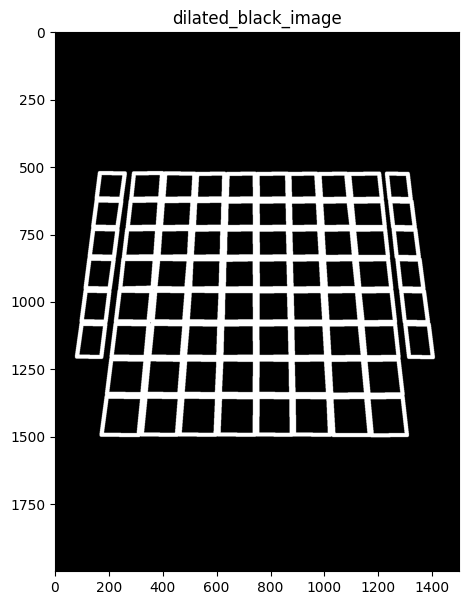

In [ ]:
# Apply dilation to the black_image_2
kernel = np.ones((7, 7), np.uint8)
dilated_black_image = cv2.dilate(black_image_2, kernel, iterations=1)

plt.figure(figsize=(9,7))
plt.title("dilated_black_image")
plt.imshow(dilated_black_image,cmap="gray")

<br>


## Find biggest contour of image

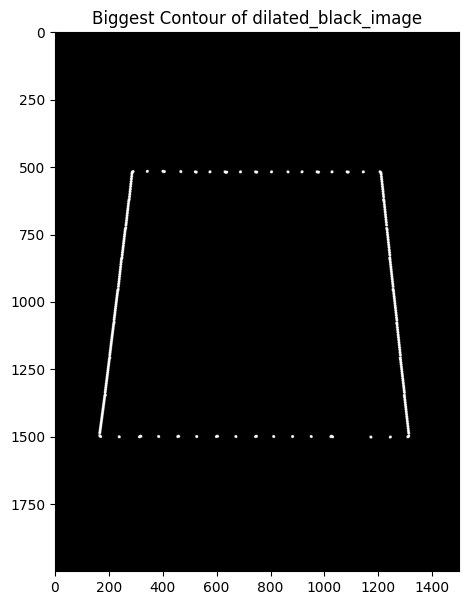

In [ ]:
# Find contours of dilated_black_image
contours, _ = cv2.findContours(dilated_black_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# take biggest contour
largest_contour = max(contours, key=cv2.contourArea)

# create black image
biggest_area_image = np.zeros_like(dilated_black_image)

# draw biggest contour to the image
cv2.drawContours(biggest_area_image,largest_contour,-1,(255,255,255),10)

plt.figure(figsize=(9,7))
plt.title("Biggest Contour of dilated_black_image")
plt.imshow(biggest_area_image,cmap="gray")

<br>


### Check if square centers falls inside of the biggest contour , it is for detecting undesired squares that exists outside of the board


In [ ]:
# Check if square centers falls inside of biggest contour

inside_squares=list()

for square in square_centers:
    point=(square[0],square[1])

    # Check if the point is inside the largest contour
    distance = cv2.pointPolygonTest(largest_contour, point, measureDist=False)

    if distance >= 0:
        inside_squares.append(square)

    else:
        continue

len(inside_squares)

64

<br>


## Sort Squares

In [ ]:
# Chess board has 64 square , 8x8 --> now sort this squares by following this 8x8 pattern

# sort y values
sorted_coordinates = sorted(inside_squares, key=lambda x: x[1], reverse=True)

# sort x values
groups = []
current_group = [sorted_coordinates[0]]

for coord in sorted_coordinates[1:]:
    if abs(coord[1] - current_group[-1][1]) < 50:
        current_group.append(coord)
    else:
        groups.append(current_group)
        current_group = [coord]

# Append the last group
groups.append(current_group)

# Sort each group by the second index (column values)
for group in groups:
    group.sort(key=lambda x: x[0])

# Combine the groups back together
sorted_coordinates = [coord for group in groups for coord in group]

sorted_coordinates[:5]

[[248.0, 1424.5, [309, 1495], [323, 1354], [191, 1353], [172, 1494]],
 [392.0, 1424.0, [451, 1494], [462, 1354], [335, 1353], [321, 1493]],
 [531.0, 1424.0, [594, 1494], [600, 1354], [472, 1353], [461, 1493]],
 [673.0, 1424.5, [739, 1494], [740, 1355], [611, 1354], [605, 1493]],
 [813.5, 1424.5, [876, 1494], [875, 1355], [750, 1354], [749, 1493]]]

<br><br>

## Add undetected squares

<font size="4">
    This function simply follow coordinates of consequtive squares , but there are some squares that needs to
    handled differently . <br><br>
    Think about first square of every row , before that square there is nothing, so it shouldnt  processed  like  consequtive squares <br><br>
    [6,14,22,30,38,46,54] and [8,16,24,32,40,48,56] , and remaining squares treated differently , for these 3 set, there is 3 different algorithms<br><br>
    Dont forget : this numbers are started from "0" , so square 6 means 7 in real chess board
</font>

In [ ]:

def fill_gaps():
    global sorted_coordinates

    addition=0

    for num in range(63):


        if num in [6,14,22,30,38,46,54]:
            if abs(sorted_coordinates[num][0]-sorted_coordinates[num+1][0])>250:

                x=sorted_coordinates[num][0]+ abs(sorted_coordinates[num][0]-sorted_coordinates[num-1][0])
                y=sorted_coordinates[num][1]

                p1=(sorted_coordinates[num][2][0]+ abs(sorted_coordinates[num][2][0]-sorted_coordinates[num-1][2][0]) , sorted_coordinates[num][2][1])
                p2=(sorted_coordinates[num][3][0]+ abs(sorted_coordinates[num][3][0]-sorted_coordinates[num-1][3][0]) , sorted_coordinates[num][3][1])
                p3=sorted_coordinates[num][3]
                p4=sorted_coordinates[num][2]



                sorted_coordinates.insert(num+1,[x,y,p1,p2,p3,p4])
                print("first statement",num+2)
                continue



        elif num in [8,16,24,32,40,48,56]:
            if abs(sorted_coordinates[num][0]-sorted_coordinates[num-8][0])>50:

                x=sorted_coordinates[num-8][0]
                y=sorted_coordinates[num+1][1]
                      # x,y,p1,p2,p3,p4
                p1=sorted_coordinates[num-8][3]
                p2=(sorted_coordinates[num-8][3][0],sorted_coordinates[num+1][3][1])
                p3=(sorted_coordinates[num-8][4][0],sorted_coordinates[num+1][3][1])
                p4=sorted_coordinates[num-8][4]

                sorted_coordinates.insert(num,[x,y,p1,p2,p3,p4])
                print("second statement",num+1)


                continue


           # net sorun var kordinat             # x,y,p1,p2,p3,p4
        elif abs(sorted_coordinates[num][1] - sorted_coordinates[num+1][1])< 50 :
            if sorted_coordinates[num+1][0] - sorted_coordinates[num][0] > 150:
                x=(sorted_coordinates[num+1][0] + sorted_coordinates[num][0])/2
                y=(sorted_coordinates[num+1][1] + sorted_coordinates[num][1])/2
                p1=sorted_coordinates[num+1][5]
                p2=sorted_coordinates[num+1][4]
                p3=sorted_coordinates[num][3]
                p4=sorted_coordinates[num][2]
                sorted_coordinates.insert(num+1,[x,y,p1,p2,p3,p4])
                print(f"third statement",num+2)
                addition+=1

    if addition!=0:
        fill_gaps()


fill_gaps()




<br>


## Write coordinate of squares to a csv file

In [ ]:
# Write coordinates to CSV file

with open('extracted-data/board-square-positions.csv', mode='w', newline='') as file:
    writer = csv.writer(file)

    # columns
    writer.writerow(['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4'])


    for coordinate in sorted_coordinates:
        writer.writerow([coordinate[2][0], coordinate[2][1],
                                 coordinate[3][0], coordinate[3][1],
                                 coordinate[4][0], coordinate[4][1],
                                 coordinate[5][0], coordinate[5][1]])



<br>


## Check coordinates of squares that are inside of CSV file

C:\Users\sirom\AppData\Local\Temp\ipykernel_8532\1136180732.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pts.append((int(row[j]), int(row[j+1])))


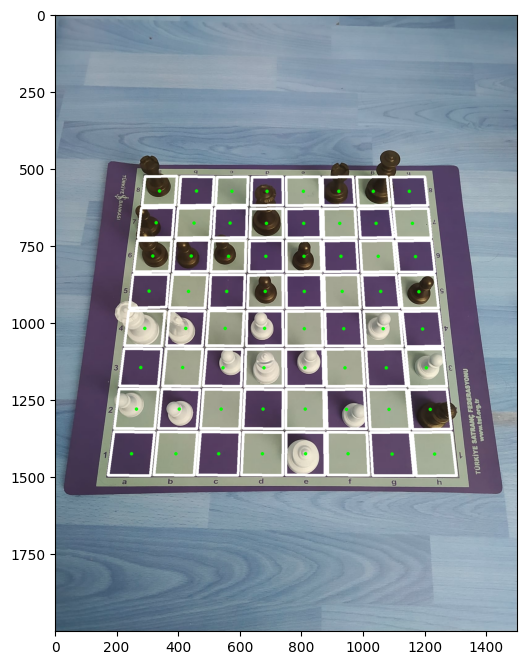

In [ ]:
# Check CSV coordinates

data = pd.read_csv("extracted-data/board-square-positions.csv") # true Coordinatesa

# Read the image

image = cv2.imread(image_path)

# Loop through each row in the DataFrame and draw polygons
for i, row in data.iterrows():
    pts = []
    for j in range(0, 8, 2):
        pts.append((int(row[j]), int(row[j+1])))
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.circle(image, (int(sorted_coordinates[i][0]),int(sorted_coordinates[i][1])), 3, (0,255,0), 3)
    cv2.polylines(image,[pts],True,(255,255,255),thickness=8)  # Change color and thickness as needed

# Display the image
plt.figure(figsize=(10,8))
plt.imshow(image)

<br>

## CSV

In [ ]:
# for creating csv files for coordinates --> Chess-Board/Board_to_csv.ipynb
coordinates=pd.read_csv("extracted-data/board-square-positions.csv")
coordinates.tail()


,x1,y1,x2,y2,x3,y3,x4,y4
59,740,617,739,525,639,526,636,618
60,861,617,859,525,750,526,751,618
61,973,617,967,525,868,526,870,618
62,1087,618,1078,525,979,526,985,619
63,1210,618,1200,525,1089,526,1098,619


<br>

## Create dictionary for squares coordinates

In [ ]:
# dictionary for every cell's boundary coordinates
# [[334, 1231], [344, 1139], [262, 1137], [247, 1228]] -->x1,y1,x2,y2,x3,y3,x4,y4
# 64 cell_value in total --> 8x8 board

coord_dict={}

cell=1
for row in coordinates.values:
    coord_dict[cell]=[[row[0],row[1]],[row[2],row[3]],[row[4],row[5]],[row[6],row[7]]]
    cell+=1

print(coord_dict[1])
print(coord_dict[2])
print(len(coord_dict))

[[309, 1495], [323, 1354], [191, 1353], [172, 1494]]
[[451, 1494], [462, 1354], [335, 1353], [321, 1493]]
64


<br>

## Label Dictionary

In [ ]:
# class values , these values are decided before training
names: ['black-bishop', 'black-king', 'black-knight', 'black-pawn', 'black-queen', 'black-rook', 'white-bishop', 'white-king', 'white-knight', 'white-pawn', 'white-queen', 'white-rook'] # type: ignore
class_dict={0:'black-bishop',1:'black-king',2:'black-knight',3:'black-pawn',4: 'black-queen',5: 'black-rook',
            6:'white-bishop',7:'white-king',8: 'white-knight',9: 'white-pawn',10: 'white-queen',11:'white-rook'}

<br>

## Make prediction


image 1/1 c:\Users\sirom\Desktop\Chess-Github\test-images\test-10.jpeg: 640x480 1 black-bishop, 1 black-king, 6 black-pawns, 2 black-queens, 2 black-rooks, 1 white-bishop, 1 white-king, 1 white-knight, 8 white-pawns, 1 white-queen, 1 white-rook, 29.9ms
Speed: 9.6ms preprocess, 29.9ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 480)


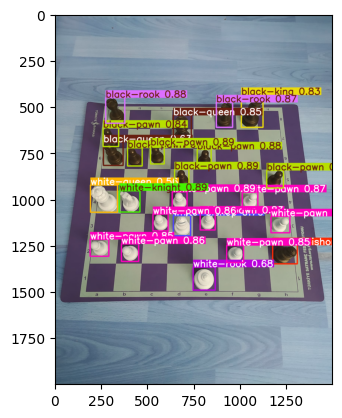

In [ ]:
# YOLOv8  model
model = YOLO("chess-model-yolov8m.pt")

# make prediction
results = model(image_path) # path to test image
im_array = results[0].plot(); # plot a BGR numpy array of predictions

plt.imshow(im_array)

<br>

### "game_list" is a list that contains information about game

In [ ]:
# list for cell number and piece id (class value)
game_list=[]

for result in results:  # results is model's prediction
    for id,box in enumerate(result.boxes.xyxy) : # box with xyxy format, (N, 4)

            x1,y1,x2,y2=int(box[0]),int(box[1]),int(box[2]),int(box[3]) # take coordinates

            # find middle of bounding boxes for x and y
            x_mid=int((x1+x2)/2)
            # add padding to y values
            y_mid=int((y1+y2)/2)+25

            for cell_value, coordinates in coord_dict.items():
                x_values = [point[0] for point in coordinates]
                y_values = [point[1] for point in coordinates]

                if (min(x_values) <= x_mid <= max(x_values)) and (min(y_values) <= y_mid <= max(y_values)):
                    a=int(result.boxes.cls[id])

                    print(f" cell :  {cell_value} --> {a} ")
                    # add cell values and piece cell_value(class value
                    game_list.append([cell_value,a])
                    break





 cell :  40 --> 3 
 cell :  26 --> 8 
 cell :  43 --> 3 
 cell :  36 --> 3 
 cell :  28 --> 9 
 cell :  45 --> 3 
 cell :  57 --> 5 
 cell :  42 --> 3 
 cell :  62 --> 5 
 cell :  31 --> 9 
 cell :  24 --> 9 
 cell :  19 --> 9 
 cell :  10 --> 9 
 cell :  14 --> 9 
 cell :  52 --> 4 
 cell :  9 --> 9 
 cell :  49 --> 3 
 cell :  21 --> 9 
 cell :  63 --> 1 
 cell :  20 --> 6 
 cell :  5 --> 11 
 cell :  41 --> 4 
 cell :  16 --> 0 
 cell :  25 --> 10 
 cell :  25 --> 7 


<br>

## Create String that contains game info

In [ ]:
# show game , if cell value exist in game_list , then print piece in that cell , otherwise print space
chess_str=""
for i in range(1, 65):

    for slist in game_list:
        if slist[0] == i:
            print(class_dict[slist[1]], end=" ")
            chess_str+=f" {class_dict[slist[1]]} "
            break
    else:
        print("space", end=" ")
        chess_str+=" space "

    if i % 8 == 0:
        print("\n")
        chess_str+="\n"

space space space space white-rook space space space 

white-pawn white-pawn space space space white-pawn space black-bishop 

space space white-pawn white-bishop white-pawn space space white-pawn 

white-queen white-knight space white-pawn space space white-pawn space 

space space space black-pawn space space space black-pawn 

black-queen black-pawn black-pawn space black-pawn space space space 

black-pawn space space black-queen space space space space 

black-rook space space space space black-rook black-king space 



<br>

## Create Classical Chess Image in .SVG format

In [ ]:
import chess
import chess.svg

def parse_coordinates(input_str):
    """
    Parse the input string to extract the positions of the chess pieces.
    """
    rows = input_str.strip().split('\n')
    chess_pieces = []
    for row in rows:  # Reversing rows to invert ranks
        pieces = row.strip().split()
        chess_pieces.extend(pieces)
    return chess_pieces


input_str=chess_str

chess_pieces = parse_coordinates(input_str)

board = chess.Board(None)

piece_mapping = {
    'white-pawn': chess.PAWN,
    'black-pawn': chess.PAWN,
    'white-knight': chess.KNIGHT,
    'black-knight': chess.KNIGHT,
    'white-bishop': chess.BISHOP,
    'black-bishop': chess.BISHOP,
    'white-rook': chess.ROOK,
    'black-rook': chess.ROOK,
    'white-queen': chess.QUEEN,
    'black-queen': chess.QUEEN,
    'white-king': chess.KING,
    'black-king': chess.KING,
    'space': None
}

for rank in range(8):
    for file in range(8):
        piece = chess_pieces[rank * 8 + file]
        if piece != 'space':
            print(rank)
            print(file)
            color = chess.WHITE if piece.startswith('white') else chess.BLACK
            piece_type = piece_mapping[piece]
            board.set_piece_at(chess.square(file, rank), chess.Piece(piece_type, color))  # Not inverting rank

svgboard = chess.svg.board(board)
with open("extracted-data/2Dboard.svg", "w") as f:
    f.write(svgboard)




0
4
1
0
1
1
1
5
1
7
2
2
2
3
2
4
2
7
3
0
3
1
3
3
3
6
4
3
4
7
5
0
5
1
5
2
5
4
6
0
6
3
7
0
7
5
7
6


<br><br>

## Convert .SVG to .PNG and display Result

Converted extracted-data/2Dboard.svg to extracted-data/Extracted-Board.png


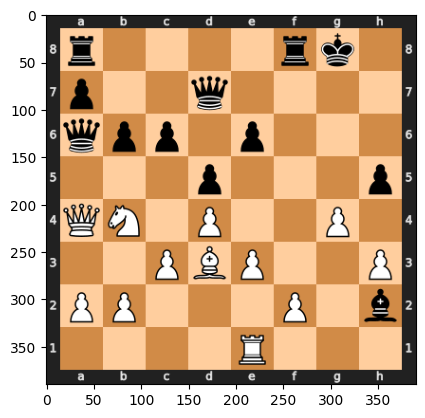

In [ ]:
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM

# Function to convert SVG to PNG
def convert_svg_to_png(svg_file_path, png_file_path):
    # Read the SVG file and convert it to a ReportLab Drawing
    drawing = svg2rlg(svg_file_path)
    # Render the drawing to a PNG file
    renderPM.drawToFile(drawing, png_file_path, fmt='PNG')
    print(f"Converted {svg_file_path} to {png_file_path}")

# Example usage
svg_file = 'extracted-data/2Dboard.svg'
png_file = 'extracted-data/Extracted-Board.png'
convert_svg_to_png(svg_file, png_file)

plt.imshow(cv2.cvtColor(cv2.imread(png_file),cv2.COLOR_BGR2RGB))

<br><br>

## Display Original Image and Converted Image

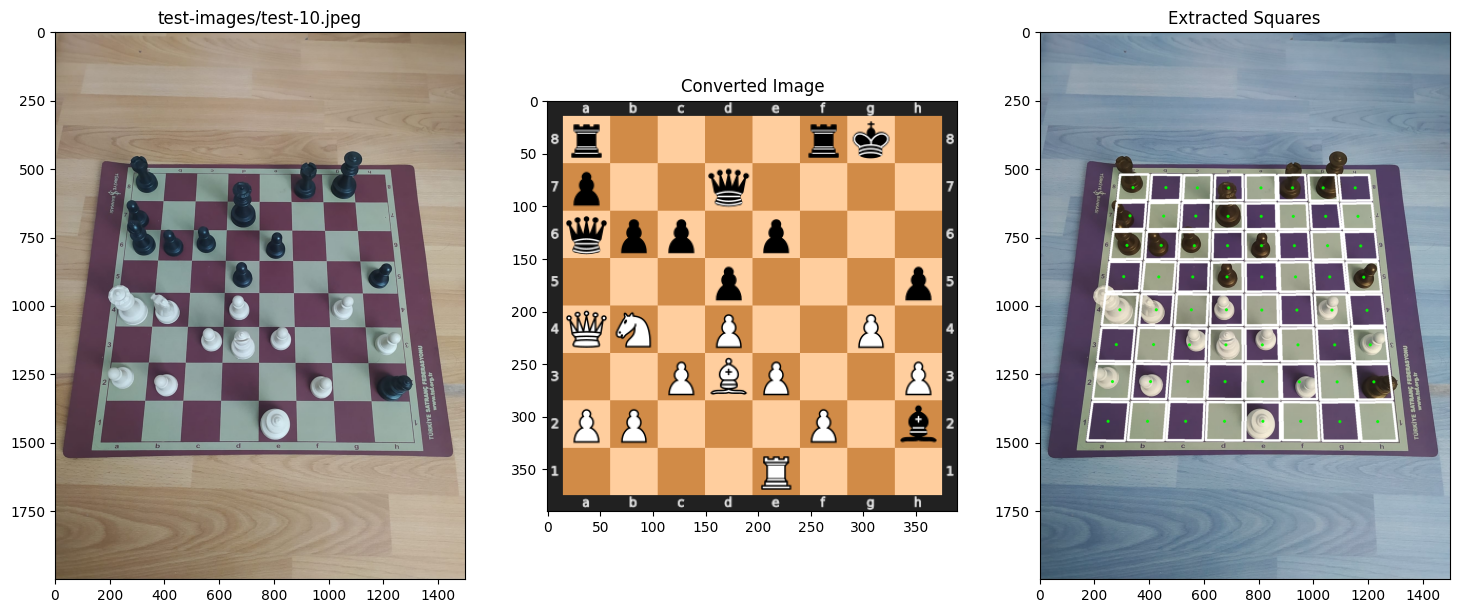

In [ ]:
plt.figure(figsize=(18, 12))  # Increase the figure size to 18x6 inches

plt.subplot(131)
plt.title(f"{image_path}")
plt.imshow(rgb_image)

plt.subplot(132)
plt.title("Converted Image")
plt.imshow(cv2.cvtColor(cv2.imread(png_file),cv2.COLOR_BGR2RGB))

plt.subplot(133)
plt.title("Extracted Squares")
plt.imshow(image)

plt.show()